## Scattered data interpolation

This notebook describes and compares several methods of scattered data interpolation.

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as optimize
import pygsvd
from sampling import Sampling
from roll_zeropad import roll_zeropad
matplotlib.rcParams['font.size'] = 16

### Richardson-Lucy 

Richardson-Lucy deconvolves by iterating on the following equations:

$$\vec{c}^{(k)} = \mathbf{A}\cdot \vec{S}_R^{(k)}$$

$$d^{(k)}_i = \frac{f_i}{c_i^{(k)}}$$

$${S}_{R,i}^{(k+1)} = {S}_{R,i}^{(k)} \left(\mathbf{A}^T \cdot \vec{d}^{(k)}\right)_i$$

In [96]:
sampling = Sampling(nsamples=1000, sigmarange=[1.0, 1.0], seed=-10)
sampling.set_flux(total_flux=1000., noise=1.e-2)

In [100]:
Sflat = np.ones(sampling.A.shape[1]) * 100.
flat = sampling.A.dot(Sflat)
sampling.flux = flat

In [101]:
flux = sampling.flux
flux_fit = flux.copy()
S_0 = np.ones(sampling.A.shape[1]) * 1000.
S_R = S_0
for i in np.arange(5000):
    c = (sampling.A.dot(S_R) + flat)
    d = flux_fit / c
    S_R = S_R * (sampling.A.T.dot(d))
    diff = np.abs(flux_fit - sampling.A.dot(S_R)).mean()
    if(diff < 0.1):
        print(i)
        break
S_R = S_R.reshape((sampling.nx, sampling.ny))

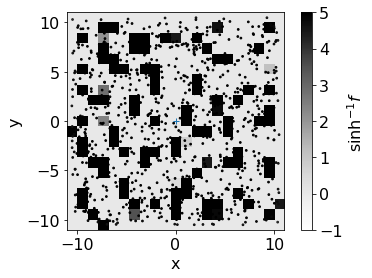

In [102]:
# S_R = np.zeros(len(S_S.flatten()))
# S_R[10 + 10 * 21] = 1000.
sampling.imshow(S_R)

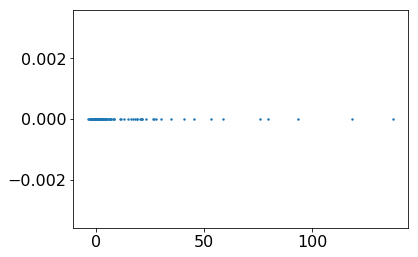

In [93]:
plt.scatter(flux_fit, sampling.A.dot(S_R.flatten()), s=2)

In [573]:
import scipy.optimize as optimize

In [574]:
def mem_function(u, A, f, llambda):
    Ar = (A.dot(u) - f)
    As = (Ar**2).sum()
    Bs = (u * np.log(u)).sum()
    val =  As + llambda * Bs
    grad = 2. * A.T.dot(Ar) + llambda * (1. + np.log(u))
    return (val, grad)

In [597]:
sampling = Sampling(nsamples=1000)
sampling.set_flux(total_flux=1000., noise=1.)
f1 = sampling.flux
f1_nonoise = sampling.flux_nonoise

sampling.set_flux(total_flux=1000., noise=1., xcen=0.5, ycen=1.3)
f2 = sampling.flux
f2_nonoise = sampling.flux_nonoise

In [598]:
M = len(ygrid)
A = np.zeros((sampling.nsamples, M))
for i in np.arange(M):
    f = sampling.fluxes(xcen=xgrid[i], ycen=ygrid[i])
    A[:, i] = f.flatten()

In [608]:
sampling.flux = f1
sampling.flux_nonoise = f1_nonoise

In [609]:
llambda = 1.e-4
S_M0 = S_S.flatten()
S_M0[S_M0 <= 0.] = 1.e-3
bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
bounds = [x for x in bounds]

results = optimize.minimize(mem_function, S_M0, args=(A, sampling.flux_nonoise, llambda),
                            method='L-BFGS-B', jac=True,
                            bounds=bounds) 

S_M_1 = results.x.reshape(nx, ny)

In [610]:
sampling.flux = f2
sampling.flux_nonoise = f2_nonoise

In [611]:
llambda = 1.e-4
S_M0 = S_S.flatten()
S_M0[S_M0 <= 0.] = 1.e-3
bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
bounds = [x for x in bounds]

results = optimize.minimize(mem_function, S_M0, args=(A, sampling.flux_nonoise, llambda),
                            method='L-BFGS-B', jac=True,
                            bounds=bounds) 

S_M_2 = results.x.reshape(nx, ny)

In [612]:
sampling.flux = f1 + f2
sampling.flux_nonoise = f1_nonoise + f2_nonoise

In [613]:
llambda = 1.e-4
S_M0 = S_S.flatten()
S_M0[S_M0 <= 0.] = 1.e-3
bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
bounds = [x for x in bounds]

results = optimize.minimize(mem_function, S_M0, args=(A, sampling.flux_nonoise, llambda),
                            method='L-BFGS-B', jac=True,
                            bounds=bounds) 

S_M_12 = results.x.reshape(nx, ny)

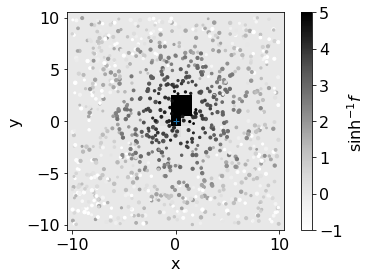

In [614]:
sampling.imshow(S_M_2 + S_M_1)

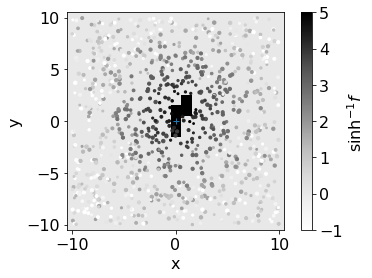

In [615]:
sampling.imshow(S_M_12)

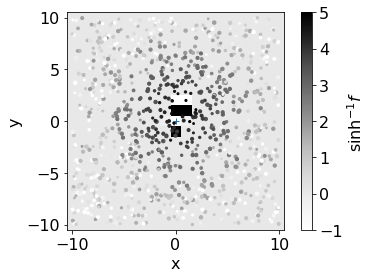

In [616]:
sampling.imshow(S_M_12 - S_M_1 - S_M_2)

In [639]:
flat = np.ones(A.shape[1]) * 100.

In [640]:
sampling.flux = sampling.flux * 0. + A.dot(flat) + np.random.normal(size=len(sampling.flux)) * 5
sampling.flux_nonoise = sampling.flux * 0. + A.dot(flat)

In [645]:
llambda = 1.e-2
S_M0 = S_S.flatten()
S_M0[S_M0 <= 0.] = 1.e-3
bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
bounds = [x for x in bounds]

results = optimize.minimize(mem_function, S_M0, args=(A, sampling.flux, llambda),
                            method='L-BFGS-B', jac=True,
                            bounds=bounds) 

S_M_flat = results.x.reshape(nx, ny)

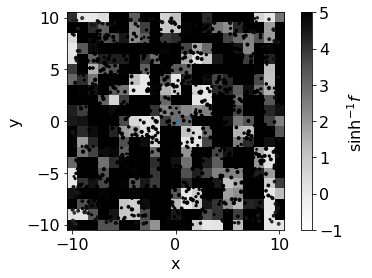

In [646]:
sampling.imshow(S_M_flat)

In [626]:
nsample = 1000
S_M_arr = np.zeros((nsample, nx, ny)) 
llambda = 1.e-4
for i in np.arange(nsample):
    sampling.set_flux(total_flux=0., noise=1.)
    sampling.flux = sampling.flux + A.dot(flat)
    S_M0 = S_S.flatten()
    S_M0[S_M0 <= 0.] = 1.e-3
    bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
    bounds = [x for x in bounds]
    results = optimize.minimize(mem_function, S_M0, args=(A, sampling.flux, llambda),
                                method='L-BFGS-B', jac=True,
                                bounds=bounds) 
    S_M_arr[i, :, :] = results.x.reshape(nx, ny)

KeyboardInterrupt: 

In [621]:
S_M_arr1d = S_M_arr.reshape(nsample, nx * ny)
C_M = np.zeros((nx * ny, nx * ny))
for i in np.arange(nx * ny):
    for j in np.arange(nx * ny):
        C_M[i, j] = (((S_M_arr1d[:, i] - S_M_arr1d[:, i].mean()) *
                      (S_M_arr1d[:, j] - S_M_arr1d[:, j].mean())).sum() /
                       np.float32(nsample))

In [622]:
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys}
CC_M = 0. * C_M
for i in np.arange(nx * ny):
    for j in np.arange(nx * ny):
        CC_M[i, j] = C_M[i, j] / np.sqrt(C_M[i, i] * C_M[j, j])
       

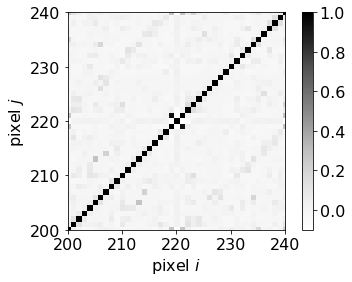

In [624]:
plt.imshow(CC_M, vmin=-0.1, vmax=1., **myargs)
nmid = (nx * ny) // 2
plt.xlim([nmid - 20, nmid + 20])
plt.ylim([nmid - 20, nmid + 20])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')
plt.savefig('../tex/figures/scattered-nnls-covar.png', dpi=300)

In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=10), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)